# Objective

Determine the best intensity threshold for the sample RCA image.

# Takeaway

The optimal intensity threshold can be defined as the intensity threshold which maximizes precision times recall. For RCA, optimal intensity threshold = 0.06.

In [1]:
from math import sqrt
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '../../FISH-annotation/Annotation')
import util

In [2]:
img_height = 450
img_path = 'rca.png'
ref_coords_path = 'rca.csv'
ref_coords_bare_path = 'rca_coords.csv'

# Plot Precision-Recall.

## Precision Recall Curve

In [3]:
correctness_threshold = 4
print('Correctness threshold = ' + str(correctness_threshold) + ' pixels.')

ref_kdt = util.csv_to_kdt(ref_coords_path, img_height)

im = imread(img_path)
im_gray = rgb2gray(im)
ref_coords = np.genfromtxt(ref_coords_bare_path, delimiter=',')

precision_list = []
recall_list = []

for threshold in np.arange(0.02, 0.18, 0.005):
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs_list = []
    for r, c, sigma in blobs_log:
        blobs_list.append([c, r])
    blobs_kdt = KDTree(blobs_list, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
        
    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    num_ref_detected = len(detected_ref)
    num_blobs_correct = len(correct_blobs)
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    precision_list.append(precision)
    recall_list.append(recall)

Correctness threshold = 4 pixels.


../../FISH-annotation/Annotation/util.py:199: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()


## Find the intensity threshold which maximizes precision * recall.

Text(0,0.5,'recall times precision')

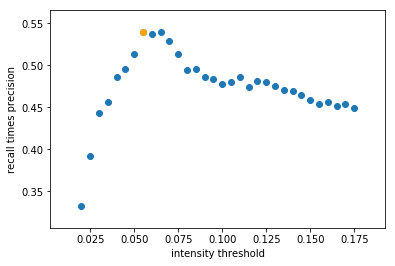

In [4]:
recall_times_precision = [recall*precision for recall, precision in zip(recall_list, precision_list)]
ind_max_recall_times_precision = np.argmax(recall_times_precision)

plt.scatter(np.arange(0.02, 0.18, 0.005), recall_times_precision)
plt.scatter([np.arange(0.02, 0.18, 0.005)[ind_max_recall_times_precision]], [recall_times_precision[ind_max_recall_times_precision]], c='orange')
plt.xlabel('intensity threshold')
plt.ylabel('recall times precision')

## Confirm that the intensity threshold which maximizes precision * recall makes sense by visual inspection on the precision-recall plot.

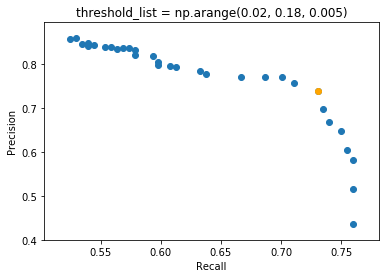

In [5]:
plt.figure()
plt.scatter(recall_list, precision_list)
plt.scatter([recall_list[ind_max_recall_times_precision]], [precision_list[ind_max_recall_times_precision]], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('threshold_list = np.arange(0.02, 0.18, 0.005)')
plt.show()

## Best intensity threshold to maximize precision * recall = 

In [6]:
best_intensity_threshold = round(np.arange(0.02, 0.18, 0.005)[ind_max_recall_times_precision], 2)
print(best_intensity_threshold)

0.06
